In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score

In [ ]:
# Load the dataset
data = pd.read_csv("uci-news-aggregator.csv")

data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


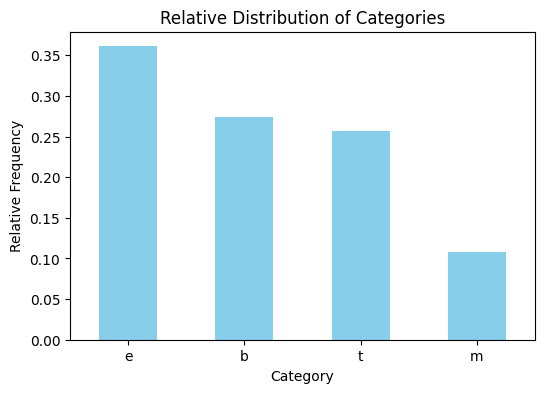

e    0.360943
b    0.274531
t    0.256485
m    0.108042
Name: CATEGORY, dtype: float64


In [ ]:
z# Count the occurrences of each category
category_counts = data['CATEGORY'].value_counts()

# Calculate relative frequencies
total_samples = len(data)
category_relative = category_counts / total_samples

# Plotting relative frequencies
plt.figure(figsize=(6, 4))
category_relative.plot(kind='bar', color='skyblue')
plt.title('Relative Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Relative Frequency')
plt.xticks(rotation=0)
plt.show()

print(category_relative)

In [ ]:
# Drop irrelevant columns from the dataset before one-hot encoding
data_for_encoding = data.drop(columns=['ID', 'URL', 'PUBLISHER', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# One-hot encode the 'CATEGORY' column
data_encoded = pd.get_dummies(data_for_encoding, columns=['CATEGORY'])

# Split the dataset into features (X) and target variable (y)
X = data_encoded.drop(columns=['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_m', 'CATEGORY_t'])  # Features (excluding the target variable)
y = data_encoded[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_m', 'CATEGORY_t']]  # Target variable

# Split the features and target variable into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert titles into numerical feature vectors using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train['TITLE'])
X_test_tfidf = vectorizer.transform(X_test['TITLE'])

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight = 'balanced')

rf_classifier.fit(X_train_tfidf, y_train)

# Predict the categories on the test set
y_pred = rf_classifier.predict(X_test_tfidf)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8912575162160883


In [ ]:
# Convert one-hot encoded vectors back to category labels
true_categories = pd.Series([y.columns[np.argmax(true_vector)] for true_vector in y_test.values], name='True_Category')
predicted_categories = pd.Series([y.columns[np.argmax(pred_vector)] for pred_vector in y_pred], name='Predicted_Category')

# Create a DataFrame to store the true and predicted values
comparison_df = pd.DataFrame({'True_Category': true_categories, 'Predicted_Category': predicted_categories})

# Display the DataFrame
comparison_df


,True_Category,Predicted_Category
0,CATEGORY_e,CATEGORY_e
1,CATEGORY_b,CATEGORY_e
2,CATEGORY_e,CATEGORY_e
3,CATEGORY_e,CATEGORY_e
4,CATEGORY_m,CATEGORY_b
...,...,...
84479,CATEGORY_b,CATEGORY_b
84480,CATEGORY_m,CATEGORY_m
84481,CATEGORY_t,CATEGORY_t
84482,CATEGORY_t,CATEGORY_t


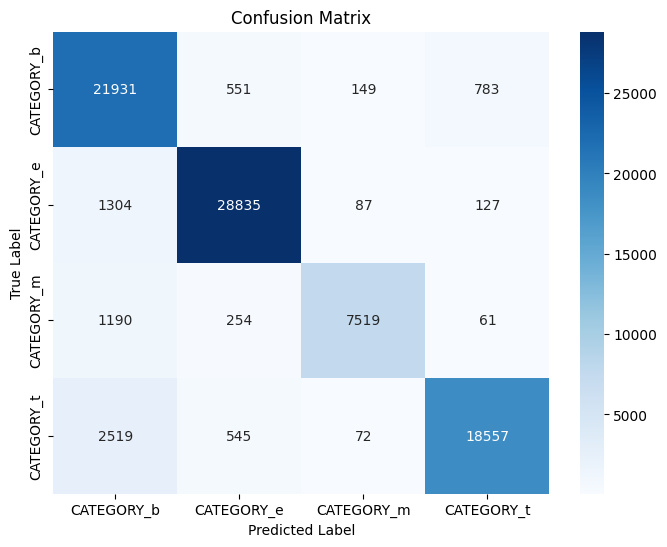

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_categories, predicted_categories)

# Get the unique class labels from y_test or y_pred
class_labels = y_test.columns

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


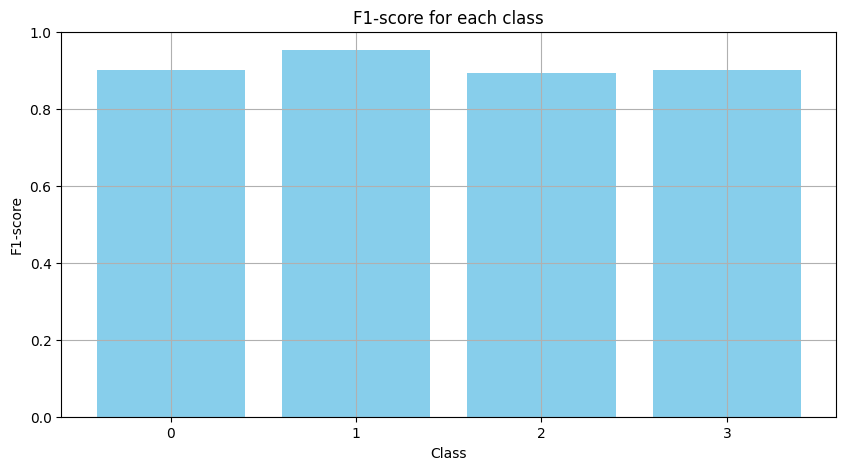

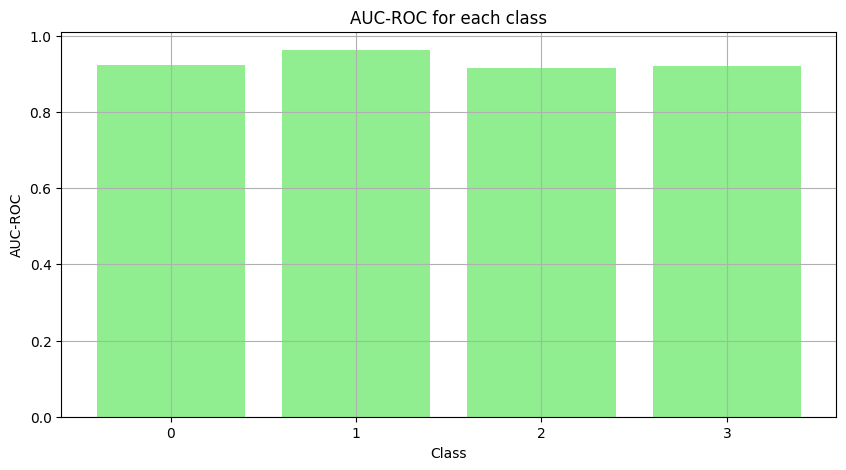

In [ ]:
# Calculate average F1-score
f1_scores = f1_score(y_test, y_pred, average='weighted')

# Calculate AUC-ROC for each class
auc_roc_scores = roc_auc_score(y_test, y_pred, average=None)

# Calculate average F1-score
average_f1_score = f1_score(y_test, y_pred, average='weighted')

# Calculate AUC-ROC for each class
auc_roc_scores = roc_auc_score(y_test, y_pred, average=None)


# Plot F1-score for each class
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(f1_scores)), f1_scores, color='skyblue')
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score for each class')
plt.xticks(np.arange(len(f1_scores)))
plt.grid(True)
plt.show()

# Plot AUC-ROC for each class
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(auc_roc_scores)), auc_roc_scores, color='lightgreen')
plt.xlabel('Class')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC for each class')
plt.xticks(np.arange(len(auc_roc_scores)))
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

# Drop irrelevant columns from the dataset before one-hot encoding
data_for_encoding = data.drop(columns=['ID', 'URL', 'PUBLISHER', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# One-hot encode the 'CATEGORY' column
data_encoded = pd.get_dummies(data_for_encoding, columns=['CATEGORY'])

# Split the dataset into features (X) and target variable (y)
X = data_encoded.drop(columns=['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_m', 'CATEGORY_t'])  # Features (excluding the target variable)
y = data_encoded[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_m', 'CATEGORY_t']]  # Target variable

# Split the features and target variable into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert titles into numerical feature vectors using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train['TITLE'])
X_test_tfidf = vectorizer.transform(X_test['TITLE'])

# Define hyperparameters
input_size = X_train_tfidf.shape[1]  # Assuming the input size is the number of features
num_classes = y_train.shape[1]  # Assuming num_classes is the number of output classes
learning_rate = 0.001
num_epochs = 50
batch_size = 32

# Create sparse tensor for training and testing data
X_train_sparse = torch.tensor(X_train_tfidf.todense()).float()
X_test_sparse = torch.tensor(X_test_tfidf.todense()).float()

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_sparse, torch.tensor(y_train.values).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_sparse, torch.tensor(y_test.values).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the neural network model
model = NeuralNetwork(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == torch.argmax(targets, 1)).sum().item()

accuracy = correct / total
print("Test Accuracy:", accuracy)


Test Accuracy: 0.8389280810567682
